# SNR Benefits of Non-Uniform Scalar Quantization

This code is provided as supplementary material of the lecture Quellencodierung.

This code illustrates
* Uniform scalar quantization of audio files with midrise and midtread characteristic
* Non-Uniform quantization with $\mu$-law characteristic
* Illustration of the segmental SNR benefits and constant SNR (almost) independent of the signal amplitude

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
from pylab import rcParams
rcParams['axes.xmargin'] = 0

Load and display wave file

In [2]:
wave_filename = '../audio/33711__acclivity__excessiveexposure.wav'
# wave_filename = '../audio/E-Core - Pingouin-Banquise_45s.wav'
# wave_filename = '../audio/KIMIKO ISHIZAKA - Goldberg Variations BWV 988 - 01 - Aria_45s.wav'

x, sampling_rate = librosa.load(wave_filename)

In [3]:
# Sample to 5 bit ... 32 quantization levels
w = 5

# fix x_max based on the current signal, leave some room
x_max = np.max([np.max(x), -np.min(x)])
Delta_x = x_max / (2**(w-1))


xh_uniform_midrise = np.sign(x)*Delta_x*(np.floor(np.abs(x)/Delta_x)+0.5) 

Compute segmental SNR (with $n_\mathsf{s} = 256$)
$$
			\textrm{segSNR}[k]\bigg|_{\mathrm{dB}} = 10\log_{10}\left(\frac{\sum_{i=1}^{n_s}(x[(k-1)n_{\mathsf{s}}+i])^2}{\sum_{i=1}^{n_s}(x[(k-1)n_{\mathsf{s}}+i]-\hat{x}[(k-1)n_{\mathsf{s}}+i])^2}\right)
$$

In [4]:
# Compute segmental SNR

# number of samples used for segmentation
seg_len = 256
segments = int(np.floor(len(x)/seg_len))

x_seg = np.reshape(x[0:segments*seg_len],(segments,seg_len))
xh_seg = np.reshape(xh_uniform_midrise[0:segments*seg_len],(segments,seg_len))
snr_uniform_midrise_seg = 10*np.log10(np.mean(np.square(x_seg),axis=1) / np.mean(np.square(xh_seg - x_seg),axis=1))

Also carry out quantization using uniform midtread quantizer

In [5]:
# fix x_max based on the current signal, leave some room
x_max = np.max(x)
Delta_x = x_max / (2**(w-1))


xh_uniform_midtread = np.sign(x)*Delta_x*np.floor(np.abs(x)/Delta_x+0.5)

# saturate
xh_max = (2**(w-1)*Delta_x - Delta_x)
xh_min = -(xh_max + Delta_x)
xh_uniform_midtread[xh_uniform_midtread >= xh_max] = xh_max
xh_uniform_midtread[xh_uniform_midtread <= xh_min] = xh_min

In [6]:
# Compute segmental SNR
x_seg = np.reshape(x[0:segments*seg_len],(segments,seg_len))
xh_seg = np.reshape(xh_uniform_midtread[0:segments*seg_len],(segments,seg_len))
snr_uniform_midtread_seg = 10*np.log10(np.mean(np.square(x_seg),axis=1) / np.mean(np.square(xh_seg - x_seg),axis=1))

### Non-Uniform Quantization with $\mu$-law characteristic

In [7]:
def uLaw(x):
    mu = 255
    y = np.array([np.sign(t)*np.log(1+mu*np.abs(t))/np.log(1+mu) for t in x])
    return y

def uLaw_inv(y):
    mu = 255
    x = np.array([np.sign(t)/mu*((1+mu)**(np.abs(t))-1) for t in y])
    return x

In [8]:
# apply mu-law compression. First normalize signal to the range [-1,1] and then un-normalize
x_ulaw = uLaw(np.array(x)/x_max)

# quantize (attention, now input signal is in the range [-1,+1], i.e., x_max = 1)
Delta_x = 1 / (2**(w-1))
quantized = np.sign(x_ulaw)*Delta_x*(np.floor(np.abs(x_ulaw)/Delta_x)+0.5) 

# apply inverse mu-law compression
xh_nonuniform = uLaw_inv(np.array(quantized))*x_max

In [9]:
# Compute segmental SNR
x_seg = np.reshape(x[0:segments*seg_len],(segments,seg_len))
xh_seg = np.reshape(xh_nonuniform[0:segments*seg_len],(segments,seg_len))
snr_nonuniform_seg = 10*np.log10(np.mean(np.square(x_seg),axis=1) / np.mean(np.square(xh_seg - x_seg),axis=1))

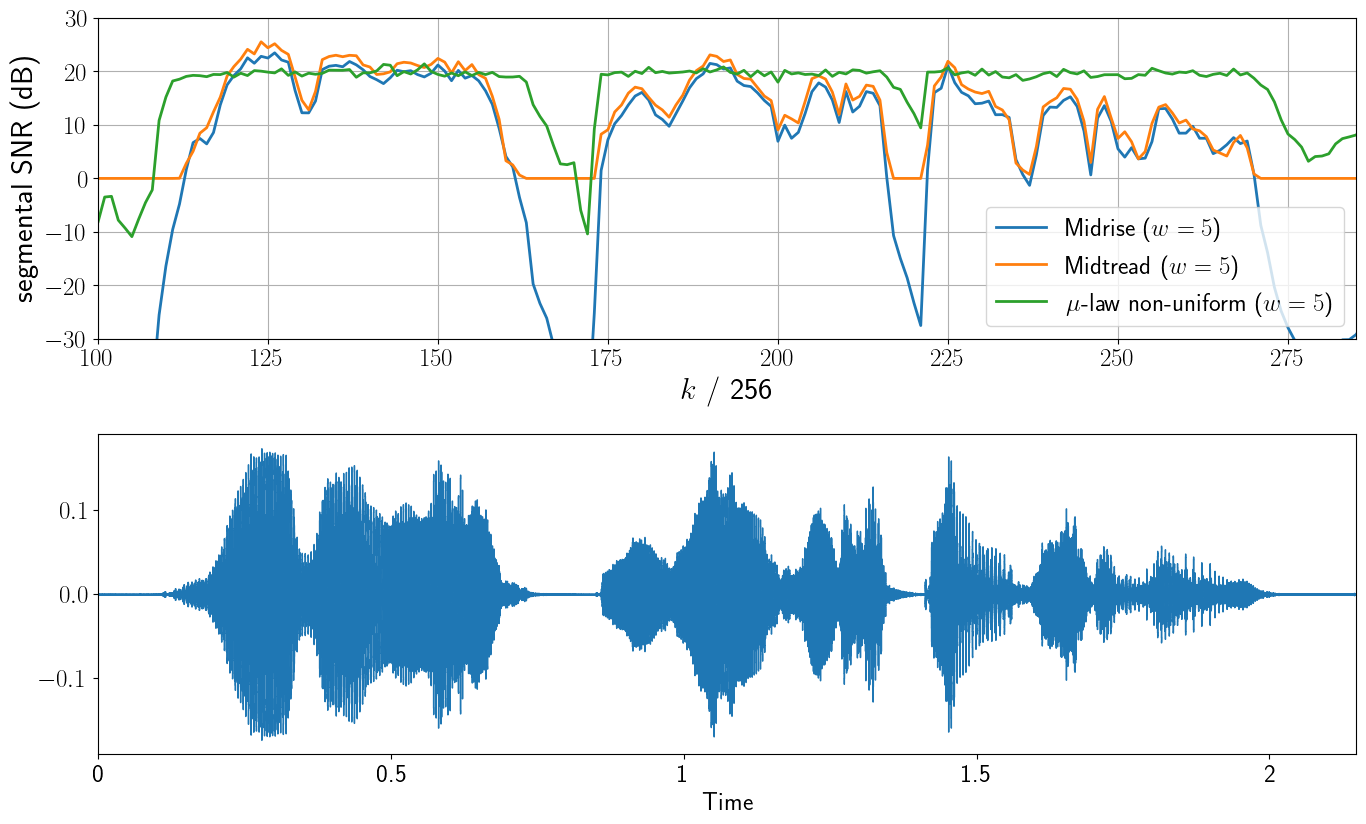

In [10]:
# plot segmental snr
font = {'size'   : 18}
plt.rc('font', **font)
plt.rc('text', usetex=True)

plt.figure(figsize=(14, 8.5))
plt.subplot(2,1,1)
plt.plot(np.arange(segments), snr_uniform_midrise_seg, linewidth=2)
plt.plot(np.arange(segments), snr_uniform_midtread_seg, linewidth=2)
plt.plot(np.arange(segments), snr_nonuniform_seg, linewidth=2)
plt.xlabel('$k$ / %d' % seg_len, fontsize=22)
plt.ylabel('segmental SNR (dB)', fontsize=22)
plt.ylim((-30,30))
plt.grid()

x_start = 25600 // seg_len
x_stop = 72960 // seg_len

plt.xlim((x_start,x_stop))
plt.legend(['Midrise ($w=5$)','Midtread ($w=5$)','$\mu$-law non-uniform ($w=5$)'])

plt.subplot(2,1,2)
librosa.display.waveshow(x[(x_start*seg_len+seg_len//2):(x_stop*seg_len+seg_len//2)], sr=sampling_rate)
plt.tight_layout()

plt.savefig('nonuniform_segmentalSNR_w%d.pdf' % w, bbox_inches='tight')